In [1]:
import numpy as np
import matplotlib.pyplot as plt

# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path

# For interactive plots, uncomment the following line
# %matplotlib widget
import os
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils     import check_random_state
from sklearn.metrics import mean_absolute_error,accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score, confusion_matrix,ConfusionMatrixDisplay


In [2]:
#read data
create_data_pickle = False
if create_data_pickle:
    files = os.listdir('data/train')
    list_of_dicts = []
    types_to_include = ['ax', 'ay', 'az', 'phone_ax', 'phone_ay', 'phone_az', 'speed', 'longitude', 'latitude', 'altitude', 'phone_steps']

    for file in tqdm(files):
        Dict = {}
        d = Recording(os.path.join('data/train',file))

        Dict['labels'] = d.labels
        for data_type in types_to_include:
            if data_type in d.data.keys():
                Dict[data_type] = d.data[data_type]
        list_of_dicts.append(Dict)

    data = pd.DataFrame(list_of_dicts)
    data.to_pickle(path='data/pickled_and_sorted_training_data.pkl.zst', compression={'method': 'zstd'})
else:
    data = pd.read_pickle('data/pickled_and_sorted_training_data.pkl.zst')
    data = data[['altitude','labels']]

In [3]:
#load pickled training 3d norm accelerometer data
import pickle
import pandas as pd

# file = open('data/accel_mag_train.pkl', 'rb')
# pickled = pickle.load(file)
# accel_mag_train =  pd.DataFrame(((x,) for x in pickled), columns=['lists'])
# print(accel_mag_train.shape)
# file.close()

labels = []
for label in data["labels"]:
    labels.extend([[label["path_idx"],label["watch_loc"]]])
labels = pd.DataFrame(labels, columns =['path_idx', "smartwatch_location"])
labels



,path_idx,smartwatch_location
0,2,1
1,0,0
2,0,0
3,2,1
4,1,1
...,...,...
391,3,2
392,4,0
393,2,1
394,3,0


In [4]:
altitude_data = [x.values[::15] for x in data["altitude"]]

In [5]:
dataframe_altitude = pd.DataFrame(altitude_data)

In [4]:


def features_extraction_common(df, prefix, extend = False): 
    if extend:
        FEATURES = ['Median', 'Numneg', 'Numpos', 'Numabovmed', 'Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Sum_f', 'Max_f', 'Peak_f', 'Peak_i_f', 'Mean_f', 'Skew_f', 'Kurtosis_f', 'Mean_d', 'STD_d', 'MAD_d', 'Var_d', 'Min_d', 'Max_d', 'SMA_d', 'Energy_d', 'IQR_d', 'Entropy_d']
    else:
        FEATURES = ['Median', 'Numneg', 'Numpos', 'Numabovmed', 'Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy']
    for idx, feature in enumerate(FEATURES):
        FEATURES[idx] = FEATURES[idx] + '_' + prefix
    
    print(FEATURES)
    Median=[];Numneg=[];Numpos=[];Numabovmed=[];
    Min=[];Max=[];Mean=[];Mad=[];Sma=[];Eng=[];Iqr=[];Entr=[];Std=[];Var=[];
    Min_d=[];Max_d=[];Mean_d=[];Mad_d=[];Sma_d=[];Eng_d=[];Iqr_d=[];Entr_d=[];Std_d=[];Var_d=[];
    Max_f=[];Peak_f=[];Peak_i_f=[];Mean_f=[];Skew_f=[];Kurtosis_f=[];Sum_f=[];
    
    # if (isinstance(df, pd.DataFrame)):
    #     print("lol")
    X = df.values

    #     if(not isinstance(X[0], (np.ndarray))):
    #         X = ([x.values] for x in df.values)
    #         print("lel")
    # else:
    #     X = ([x] for x in df)
    #     print("amcik")
    ## TIME DOMAIN ##
    #list of lists of lists, ugly as fuck but it works 
    for trace in X:
        recording = [trace.values]
        Median.append(np.median(recording[0]))
        Numneg.append(np.sum(np.array(recording[0]) < 0, axis=0))
        Numpos.append(np.sum(np.array(recording[0]) > 0, axis=0))
        Numabovmed.append(np.sum(np.array(recording[0]) > np.median(recording[0]), axis=0))

        Mean.append(np.mean(recording[0]))
        Std.append(np.std(recording[0]))
        #median absolute deviation
        Mad.append(stats.median_abs_deviation(recording[0], scale=1))
        Var.append(np.var(recording[0]))
        Min.append(np.min(recording[0]))
        Max.append(np.max(recording[0]))
        #Signal Magnitude Area
        Sma.append(np.sum(recording[0]))
        #energy measure
        Eng.append(np.sum(recording[0]**2)/len(recording[0]))
        Iqr.append(stats.iqr(recording[0]))
        Entr.append(stats.entropy(recording[0]))
        if extend:
            ## FREQ DOMAIN ##
            ft = np.abs(fft(recording[0]))
            Sum_f.append(np.sum(ft))
            Max_f.append(np.max(ft))
            Peak_f.append(np.max((ft)))
            Peak_i_f.append(np.argmax(ft))
            Mean_f.append(np.mean(ft))
            Skew_f.append(stats.skew(ft))
            Kurtosis_f.append(stats.kurtosis(ft))

            #derivative
            f = np.gradient(recording[0])
            Mean_d.append(np.mean(recording[0]))
            Std_d.append(np.std(recording[0]))
            #median absolute deviation
            Mad_d.append(stats.median_abs_deviation(recording[0], scale=1))
            Var_d.append(np.var(recording[0]))
            Min_d.append(np.min(recording[0]))
            Max_d.append(np.max(recording[0]))
            #Signal Magnitude Area
            Sma_d.append(np.sum(recording[0]))
            #energy measure
            Eng_d.append(np.sum(recording[0]**2)/len(recording[0]))
            Iqr_d.append(stats.iqr(recording[0]))
            Entr_d.append(stats.entropy(recording[0]))
    if extend:
        #Create dataframe from features
        df_features = pd.DataFrame(index = [FEATURES], 
                                data = [Median, Numneg, Numpos, Numabovmed, Mean,Std, Mad, Var, Min, Max, Sma, Eng, Iqr, Entr, Sum_f, Max_f, Peak_f, Peak_i_f, Mean_f, Skew_f, Kurtosis_f, Mean_d ,Std_d, Mad_d, Var_d, Min_d, Max_d, Sma_d, Eng_d, Iqr_d, Entr_d])
    
    else:
        df_features = pd.DataFrame(index = [FEATURES], 
                                data = [Median, Numneg, Numpos, Numabovmed, Mean,Std, Mad, Var, Min, Max, Sma, Eng, Iqr, Entr])
    
    return df_features

# def features_extraction_path(df, prefix): 



In [126]:
#extract features from accelerometer norm and get rid of multiindex
# accel_mag_features = pd.DataFrame.transpose(features_extraction_common(accel_mag_train,"acc"))
# accel_mag_features.columns = accel_mag_features.columns.map(''.join)


features_ax = pd.DataFrame.transpose(features_extraction_common(data['ax'],"ax"))
features_ax.columns = features_ax.columns.map(''.join)

features_ay = pd.DataFrame.transpose(features_extraction_common(data['ay'],"ay"))
features_ay.columns = features_ay.columns.map(''.join)

features_az = pd.DataFrame.transpose(features_extraction_common(data['az'],"az"))
features_az.columns = features_az.columns.map(''.join)

# features_mx = pd.DataFrame.transpose(features_extraction_common(data['mx'],"mx"))
# features.columns = features.columns.map(''.join)

# features_my = pd.DataFrame.transpose(features_extraction_common(data['my'],"my"))
# features.columns = features.columns.map(''.join)

# features_mz = pd.DataFrame.transpose(features_extraction_common(data['mz'],"mz"))
# features.columns = features.columns.map(''.join)

# features_gx = pd.DataFrame.transpose(features_extraction_common(data['gx'],"gx"))
# features.columns = features.columns.map(''.join)

# features_gy = pd.DataFrame.transpose(features_extraction_common(data['gy'],"gy"))
# features.columns = features.columns.map(''.join)

# features_gz = pd.DataFrame.transpose(features_extraction_common(data['gz'],"gz"))
# features.columns = features.columns.map(''.join)

['Median_ax', 'Numneg_ax', 'Numpos_ax', 'Numabovmed_ax', 'Mean_ax', 'STD_ax', 'MAD_ax', 'Var_ax', 'Min_ax', 'Max_ax', 'SMA_ax', 'Energy_ax', 'IQR_ax', 'Entropy_ax']
['Median_ay', 'Numneg_ay', 'Numpos_ay', 'Numabovmed_ay', 'Mean_ay', 'STD_ay', 'MAD_ay', 'Var_ay', 'Min_ay', 'Max_ay', 'SMA_ay', 'Energy_ay', 'IQR_ay', 'Entropy_ay']
['Median_az', 'Numneg_az', 'Numpos_az', 'Numabovmed_az', 'Mean_az', 'STD_az', 'MAD_az', 'Var_az', 'Min_az', 'Max_az', 'SMA_az', 'Energy_az', 'IQR_az', 'Entropy_az']


In [5]:
# from scipy.signal import find_peaks
# altitude_gradients = []
# for sample in altitude_data:
#     altitude_gradients.append(np.gradient(sample))


def calc_altitude_features(df):
    FEATURES = ['min', 'max', 'amp', 'len', 'gain']
    for idx, feature in enumerate(FEATURES):
        FEATURES[idx] = FEATURES[idx] + '_alt' 
    
    
    Min=[]; Max=[]; amp=[];leng=[];gain=[];

    X = df.values

    #list of lists of lists, ugly as fuck but it works 
    for recording in X:
        Min.append(min(recording.values))
        Max.append(max(recording.values))
        #fit altitude data to a linear function to determine whether we are climbing or descending
        x = np.arange(0,len(recording.values),1)
        m,b = np.polyfit(x, recording.values, 1)
        amp.append(m*1000)
        leng.append(len(recording.values))

        gain.append(m*len(recording.values))
        df_features = pd.DataFrame(index = [FEATURES],  data = [Min, Max, amp, leng, gain])

    return df_features
        
features_alt = pd.DataFrame.transpose(calc_altitude_features(data['altitude']))
features_alt.columns = features_alt.columns.map(''.join)    
features_alt       

,min_alt,max_alt,amp_alt,len_alt,gain_alt
0,406.367990,453.602028,7.404984,7322.0,54.219293
1,360.860995,450.327928,7.952432,6496.0,51.658995
2,455.199982,502.500000,7.110081,7427.0,52.806574
3,465.014834,500.782434,5.239817,6497.0,34.043088
4,456.799988,503.199982,6.495312,7816.0,50.767362
...,...,...,...,...,...
391,404.376166,451.976713,-11.343737,4070.0,-46.169011
392,401.324841,451.386381,-6.749541,7739.0,-52.234695
393,456.144868,503.000000,5.717292,9347.0,53.439524
394,453.799988,513.000000,-10.747140,5700.0,-61.258698


In [26]:
#### Try to make slopes based on not every signal but on every 20th signal or so

In [6]:
watch_bearing_features = pd.read_pickle('data/watch_bearing_directions.pkl.zst')
phone_bearing_features = pd.read_pickle('data/phone_bearing_directions.pkl.zst')

total = pd.concat([features_alt, watch_bearing_features, phone_bearing_features],axis=1)
# total = pd.concat([total, features_ax, features_ay,features_az],axis=1)
# phone_bearing_features

total.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_names = total.columns
# total

RandomForestClassifier(n_estimators=475, n_jobs=-1, random_state=12)
0.7
1.0


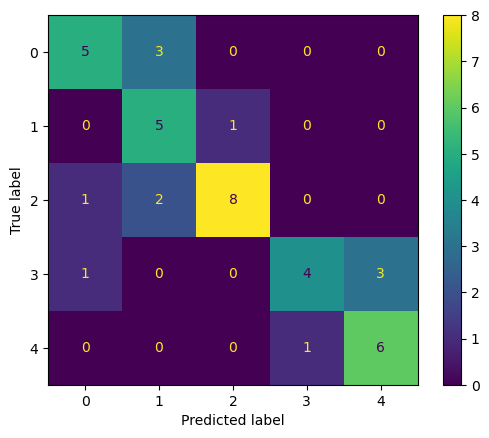

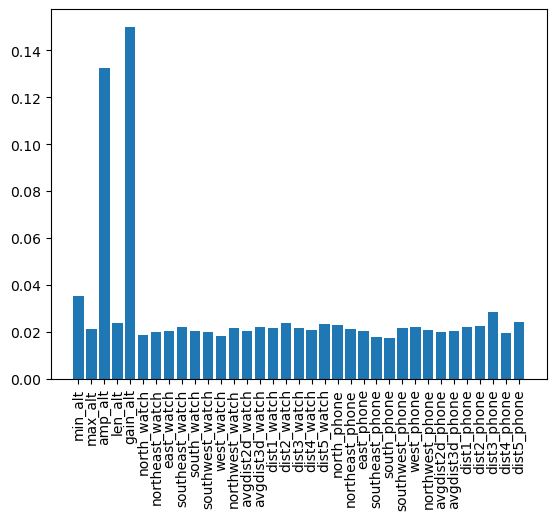

In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

def split_and_train(X_train,y_train):

    X_train.columns = [''] * len(X_train.columns)
    X_train.fillna(0, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X_train.to_numpy(), y_train.to_numpy(), test_size=0.1, random_state=69)

    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train) 
    #X_test = scaler.fit_transform(X_test) 

    

    # Instantiate model with 1000 decision trees, use all cores
    rf = RandomForestClassifier(n_jobs=-1, random_state=12)
    # Use random search to find the best hyperparameters
    # param_dist = {'n_estimators': randint(50,500),'max_depth': randint(1,20)}
    # rand_search = RandomizedSearchCV(rf, 
    #                              param_distributions = param_dist, 
    #                              n_iter=50, 
    #                              cv=5,
    #                              n_jobs=-1)

    param_dist = {'n_estimators':np.arange(50,500,25) }
    rand_search = GridSearchCV(rf, param_grid=param_dist, cv=5, n_jobs=-1)
    # rand_search = rf
    # Fit the random search object to the data
    rand_search.fit(X_train, y_train)
    y_pred = np.rint(rand_search.predict(X_test))

    # print(y_pred)
    return rand_search,y_pred,y_test,X_train,X_test,y_train

rf_model,y_pred,y_test,X_train,X_test,y_train = split_and_train(total,labels["path_idx"])

print(rf_model.best_estimator_)
print(accuracy_score(y_pred,y_test))
print(accuracy_score(np.rint(rf_model.predict(X_train)),y_train))




cmat = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cmat)
cm_display.plot()
plt.show() 
 
plt.bar(feature_names, rf_model.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.show()


In [16]:
def test_sensor_combinations():
    maxi = 0
    for i in range(1,16):
        feat = []
        print(i)
        print("[", end='')
        if(i&1):
            feat.append(features)
            print("features, ", end='')
        if(i&(1<<1)):
            feat.append(altitude_gradients)
            print("altitude_gradients, ", end='')
        if(i&(1<<2)):
            feat.append(labels["smartwatch_location"])
            print("smartwatch_location, ", end='')
        if(i&(1<<3)):
            feat.append(bearing_features)
            print("bearing_features, ", end='')
        print("]")
        feat = pd.concat(feat, axis=1)
        rf_model,y_pred,y_test,X_train,X_test = split_and_train(feat,labels["path_idx"])
        acc= accuracy_score(y_pred,y_test)
        if acc > maxi:
            maxi = acc
        print(acc)
    print(maxi)



test_sensor_combinations()

1
[features, ]


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=35)
0.3375
2
[altitude_gradients, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=40)
0.3875
3
[features, altitude_gradients, ]
RandomForestClassifier(n_jobs=-1, random_state=50)
0.525
4
[smartwatch_location, ]
RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=45)
0.1875
5
[features, smartwatch_location, ]
RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=45)
0.3
6
[altitude_gradients, smartwatch_location, ]
RandomForestClassifier(n_jobs=-1, random_state=40)
0.4875
7
[features, altitude_gradients, smartwatch_location, ]
RandomForestClassifier(n_estimators=350, n_jobs=-1, random_state=40)
0.4375
8
[bearing_features, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=40)
0.125
9
[features, bearing_features, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=55)
0.3125
10
[altitude_gradients, bearing_features, ]
RandomForestClassifier(n_estimator

In [14]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)
feature_list = ['Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Sum_f', 'Max_f', 
                'Peak_f', 'Peak_i_f', 'Mean_f', 'Skew_f', 'Kurtosis_f', 'Mean_d', 'STD_d', 'MAD_d', 'Var_d', 'Min_d', 
                'Max_d', 'SMA_d', 'Energy_d', 'IQR_d', 'Entropy_d','slopes']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [13]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

NameError: name 'importances' is not defined

In [112]:
print(data["labels"].loc[10])
d = Recording("data/train/train_trace_010.pkl")
print(d.labels)

print(labels["path_idx"][10])

{'path_idx': 0, 'activities': [1], 'step_count': None, 'watch_loc': 2}
{'path_idx': 0, 'activities': [1], 'step_count': None, 'watch_loc': 2}
0
